In [78]:
import numpy as np
import pandas as pd
import torch
from importlib.metadata import version
import re
import tiktoken
from torch.utils.data import Dataset, DataLoader
import math
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import os
import torch.nn.functional as F
import json

In [79]:
# Load the raw text from the file
raw_text = ""
# with open("../data/the-verdict.txt", "r", encoding="utf-8") as file:
with open("../data/frankenstein.txt", "r", encoding="utf-8") as file:
    raw_text = file.read()

# Calculate the total length of the text
total_length = len(raw_text)

# Calculate the split index (90% for training, 10% for validation)
split_index = int(0.9 * total_length)

# Split the text into training and validation sets
train_data = raw_text[:split_index]
val_data = raw_text[split_index:]

# Print the lengths for verification
print(f"Total length of the text: {total_length} characters")
print(f"Length of train_data: {len(train_data)} characters")
print(f"Length of val_data: {len(val_data)} characters")

Total length of the text: 438807 characters
Length of train_data: 394926 characters
Length of val_data: 43881 characters


In [80]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Create chunks
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

        # Handle the last chunk if it's smaller than max_length
        if len(token_ids) > max_length:
            last_start = max(len(token_ids) - max_length - 1, 0)
            input_chunk = token_ids[last_start:last_start + max_length]
            target_chunk = token_ids[last_start + 1:last_start + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
        elif len(token_ids) > 1:
            input_chunk = token_ids[:-1]
            target_chunk = token_ids[1:]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]


def create_dataloader_v1(txt, batch_size=4, max_length=1024, stride=1024, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader

In [81]:
# Create the data loaders
train_dataloader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=256,
    stride=256,
    shuffle=True,
    drop_last=True,
    num_workers=0,
)

val_dataloader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=256,
    stride=256,
    shuffle=False,
    drop_last=False,
    num_workers=0,
)

In [82]:
# Number of batches in the training data loader
num_train_batches = len(train_dataloader)
print(f"Number of batches in train_dataloader: {num_train_batches}")

# Number of batches in the validation data loader
num_val_batches = len(val_dataloader)
print(f"Number of batches in val_dataloader: {num_val_batches}")

# Batch size
print(f"Batch size: {train_dataloader.batch_size}")  # Should be 2

Number of batches in train_dataloader: 187
Number of batches in val_dataloader: 21
Batch size: 2


In [83]:
total_train_tokens = sum(len(sample[0]) for sample in train_dataloader.dataset)
total_val_tokens = sum(len(sample[0]) for sample in val_dataloader.dataset)
print(f"Total number of tokens in train_dataloader: {total_train_tokens}")
print(f"Total number of tokens in val_dataloader: {total_val_tokens}")

Total number of tokens in train_dataloader: 96000
Total number of tokens in val_dataloader: 10752


In [84]:
# Tokenize the entire train_data and val_data
tokenizer = tiktoken.get_encoding("gpt2")

# Tokenize train_data
train_tokens = tokenizer.encode(train_data)
print(f"Total number of tokens in train_data: {len(train_tokens)}")

# Tokenize val_data
val_tokens = tokenizer.encode(val_data)
print(f"Total number of tokens in val_data: {len(val_tokens)}")

# Total number of tokens in raw_text
total_tokens = tokenizer.encode(raw_text)
print(f"Total number of tokens in raw_text: {len(total_tokens)}")

Total number of tokens in train_data: 95756
Total number of tokens in val_data: 10605
Total number of tokens in raw_text: 106361


In [85]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch) # [B, T, V]

    flattened_logits = logits.view(-1, logits.size(-1))  # [6, 50257]
    flattened_targets = target_batch.view(-1).long()  # [6]

    loss = F.cross_entropy(flattened_logits, flattened_targets)

    return loss

In [86]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    model.eval()
    total_loss = 0.0
    count_batches = 0

    with torch.no_grad():
        for batch_idx, (input_batch, target_batch) in enumerate(data_loader):
            if num_batches is not None and batch_idx >= num_batches:
                break

            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
            count_batches += 1

    if count_batches == 0:
        return 0.0

    avg_loss = total_loss / count_batches
    return avg_loss

In [87]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda


In [88]:
def generate_text_simple(model, batch, n_tokens, max_context):
    model.eval()
    batch_size, seq_len = batch.shape
    generated_tokens = torch.zeros((batch_size, n_tokens), dtype=torch.long, device=batch.device)

    current_context = batch.clone()

    for i in range(n_tokens):
        with torch.no_grad():
            logits = model(current_context) # (batch_size, seq_len, vocab_size)

        last_logits = logits[:, -1, :] # (batch_size, vocab_size)

        probs = F.softmax(last_logits, dim=-1) # (batch_size, vocab_size)

        next_token = torch.argmax(probs, dim=-1) # (batch_size,)

        generated_tokens[:, i] = next_token

        next_token = next_token.unsqueeze(-1)  # adds a dimension for concat (batch_size, 1)

        current_context = torch.cat([current_context, next_token], dim=1)
        if current_context.shape[1] > max_context:
            current_context = current_context[:, -max_context:]

    return generated_tokens

In [89]:
def text_to_token_ids(text, tokenizer=None, add_batch_dim=True):
    """
    Encode un texte en IDs de tokens et ajoute une dimension batch si nécessaire.

    Args:
        text (str): Texte à encoder.
        tokenizer: Tokenizer à utiliser (par défaut, GPT-2).
        add_batch_dim (bool): Si True, ajoute une dimension batch (forme (1, seq_len)).

    Returns:
        torch.Tensor: Tenseur des IDs de tokens.
    """
    if tokenizer is None:
        tokenizer = tiktoken.get_encoding("gpt2")
    tokens = tokenizer.encode(text)
    tensor = torch.tensor(tokens, dtype=torch.long)
    return tensor.unsqueeze(0) if add_batch_dim else tensor


def token_ids_to_text(token_ids, tokenizer=None):
    """
    Décode des IDs de tokens en texte.

    Args:
        token_ids (torch.Tensor): Tenseur des IDs de tokens (forme (seq_len,) ou (batch_size, seq_len)).
        tokenizer: Tokenizer à utiliser (par défaut, GPT-2).

    Returns:
        str: Texte décodé.
    """
    if tokenizer is None:
        tokenizer = tiktoken.get_encoding("gpt2")
    # Gestion des batches : si batch_size > 1, on ne prend que la première séquence
    if token_ids.dim() == 2:
        token_ids = token_ids[0]
    return tokenizer.decode(token_ids.tolist())

In [90]:
class FeedForward(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.layer1 = nn.Linear(emb_size, 4*emb_size)
        self.gelu = nn.GELU()
        self.layer2 = nn.Linear(4*emb_size, emb_size)

    def forward(self, x):
        return self.layer2(self.gelu(self.layer1(x)))

In [91]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))  # Vecteur d'échelle entraînable
        self.shift = nn.Parameter(torch.zeros(emb_dim))  # Vecteur de décalage entraînable

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)  # Moyenne par ligne (batch)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)  # Variance par ligne (batch)
        output = self.scale * ((x - mean) / (torch.sqrt(variance) + self.eps)) + self.shift
        return output

In [92]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, input_dim, d_out=2, num_head=2, dropout=0.0, qkv_bias=False, out_bias=False):
        super().__init__()
        assert d_out % num_head == 0 # d_out must be divisible by num_head
        self.d_out = d_out
        self.num_head = num_head
        self.head_dim = d_out // num_head
        self.attn_dropout = torch.nn.Dropout(dropout)

        # linear projections for query, key and value
        self.W_query = torch.nn.Linear(input_dim, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(input_dim, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(input_dim, d_out, bias=qkv_bias)

        # output projection to combine heads
        self.out_proj = torch.nn.Linear(d_out, d_out, bias=out_bias)

    def forward(self, x):
        # x: (T, D) or (B, T, D) -> returns (T, d_out) or (B, T, d_out)
        squeezed = False
        if x.dim() == 2:
            x = x.unsqueeze(0)
            squeezed = True

        B, T, _ = x.shape

        # project to Q, K, V -> (B, T, d_out)
        q = self.W_query(x)
        k = self.W_key(x)
        v = self.W_value(x)

        # reshape to separate heads: (B, T, num_head, head_dim) -> (B, num_head, T, head_dim)
        q = q.view(B, T, self.num_head, self.head_dim).transpose(1,2)  # (B, num_head, T, head_dim)
        k = k.view(B, T, self.num_head, self.head_dim).transpose(1,2)  # (B, num_head, T, head_dim)
        v = v.view(B, T, self.num_head, self.head_dim).transpose(1,2)  # (B, num_head, T, head_dim)

        # attention scores: use k.transpose to get (B, num_head, head_dim, T), result (B, num_head, T, T)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # causal mask to prevent attending to future positions
        mask = torch.triu(torch.ones(T, T, device=scores.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float('-inf'))

        # attention weights
        attention = torch.softmax(scores, dim=-1)
        attention = self.attn_dropout(attention)

        # combine attention with values -> (B, num_head, T, head_dim)
        out = torch.matmul(attention, v)

        # transpose and merge heads -> (B, T, d_out)
        out = out.transpose(1, 2).contiguous().view(B, T, self.d_out)

        # final linear projection
        out = self.out_proj(out)

        if squeezed:
            return out.squeeze(0)
        return out

In [93]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config["vocab_size"]
        self.context_length = config["context_length"]
        self.emb_dim = config["emb_dim"]
        self.n_heads = config["n_heads"]
        self.n_layers = config["n_layers"]
        self.drop_rate = config["drop_rate"]
        self.qkv_bias = config["qkv_bias"]
        self.out_bias = config["out_bias"]

        self.layerNorm1 = LayerNorm(self.emb_dim)
        self.mha = MultiHeadAttention(self.emb_dim, self.emb_dim, self.n_heads, self.drop_rate, self.qkv_bias, self.out_bias)
        self.dropout1 = nn.Dropout(self.drop_rate)
        
        self.layerNorm2 = LayerNorm(self.emb_dim)
        self.feedForward = FeedForward(self.emb_dim)
        self.dropout2 = nn.Dropout(self.drop_rate)

    def forward(self, x):
        # First residual block: Multi-Head Attention
        shortcut = x
        x = self.layerNorm1(x)
        x = self.mha(x)
        x = self.dropout1(x)
        x = x + shortcut  # Residual connection
        
        # Second residual block: Feed Forward
        shortcut = x
        x = self.layerNorm2(x)
        x = self.feedForward(x)
        x = self.dropout2(x)
        x = x + shortcut  # Residual connection
        
        return x

In [94]:
class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config["vocab_size"]
        self.context_length = config["context_length"]
        self.emb_dim = config["emb_dim"]
        self.n_heads = config["n_heads"]
        self.n_layers = config["n_layers"]
        self.drop_rate = config["drop_rate"]
        self.qkv_bias = config["qkv_bias"]
        self.out_bias = config["out_bias"]

        self.token_embedding = nn.Embedding(self.vocab_size, self.emb_dim) # 50257 * 768 = 38,605,056
        self.pos_embedding_layer = torch.nn.Embedding(self.context_length, self.emb_dim) # 1024 * 768 = 786,432

        self.dropout = nn.Dropout(self.drop_rate)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(config) for _ in range(self.n_layers)]) 
        # LayerNorm1 -> 2 * 768 = 1,536
        # qkv + out -> (3 * (768 * 768)) + (768 * 768) = 2,359,296
        # 2,359,296 * 12 = 28,311,552
        # LayerNorm2 -> 2 * 768 = 1,536
        # FeedForward -> 768 * (4 * 768) + (4 * 768) * 768 = 4,718,592

        self.layerNorm = LayerNorm(self.emb_dim) # 2 * 768 = 1,536

        self.inverseEmbedding = nn.Linear(self.emb_dim, self.vocab_size, bias=False) # 768 * 50257 = 38,605,056

    def forward(self, x):
        # x: (batch_size, context_length)
        batch_size, seq_len = x.shape

        token_embeddings = self.token_embedding(x)

        pos_embeddings = self.pos_embedding_layer(torch.arange(seq_len, device=x.device))  # (seq_len, emb_dim)
        pos_embeddings = pos_embeddings.unsqueeze(0)  # (1, seq_len, emb_dim)

        x = token_embeddings + pos_embeddings
        x = self.dropout(x)

        for block in self.transformer_blocks:
            x = block(x)

        x = self.layerNorm(x)

        logits = self.inverseEmbedding(x)
        
        return logits

In [95]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_embedding_layer.weight.shape[0]

    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            batch=encoded,
            n_tokens=50,
            max_context=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(start_context, decoded_text.replace("\n", " "))
    model.train()


def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter,
                       start_context, tokenizer):

    model.to(device)

    train_losses = []
    val_losses = []
    tokens_seen = []

    tokens_per_batch = train_loader.batch_size * train_loader.dataset[0][0].shape[0]

    total_tokens = 0

    for epoch in range(num_epochs):
        model.train()
        for step, (input_batch, target_batch) in enumerate(train_loader):
            # 1) Forward + loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            # 2) Backward
            optimizer.zero_grad()
            loss.backward()

            # 3) Optimizer step
            optimizer.step()

            total_tokens += tokens_per_batch

            # 4) Évaluation périodique
            if (step + 1) % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                print(
                    f"Epoch {epoch+1}/{num_epochs}, "
                    f"Step {step+1}, "
                    f"Train loss: {train_loss:.4f}, "
                    f"Val loss: {val_loss:.4f}"
                )

                # 5) Générer un exemple de texte
                generate_and_print_sample(
                    model, tokenizer, device, start_context
                )

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                tokens_seen.append(total_tokens)


    return model, train_losses, val_losses, tokens_seen

In [96]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size (+1 for special token)
    "context_length": 256, # Context length (reduced to avoid computation load)
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate (common for GPT and later iterations)
    "qkv_bias": False,       # Query-Key-Value bias
    "out_bias": False       # Out projection bias
}

torch.manual_seed(123)

my_model = GPTModel(GPT_CONFIG_124M)
optimizer = torch.optim.AdamW(my_model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 20
eval_freq = 5
eval_iter = 5
start_context = "Every effort moves you"

my_model, train_losses, val_losses, tokens_seen = train_model_simple(my_model, train_dataloader, val_dataloader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer)

Epoch 1/20, Step 5, Train loss: 8.4866, Val loss: 8.5742
Every effort moves you                                                   
Epoch 1/20, Step 10, Train loss: 7.4695, Val loss: 7.6411
Every effort moves you                                                   
Epoch 1/20, Step 15, Train loss: 7.2650, Val loss: 7.2700
Every effort moves you , and                                 ,,,,,,,, the      
Epoch 1/20, Step 20, Train loss: 7.0669, Val loss: 7.2149
Every effort moves you                                                   
Epoch 1/20, Step 25, Train loss: 7.1755, Val loss: 7.1455
Every effort moves you                                                   
Epoch 1/20, Step 30, Train loss: 6.8738, Val loss: 7.0722
Every effort moves you  the                                                 
Epoch 1/20, Step 35, Train loss: 6.9363, Val loss: 6.9804
Every effort moves you , and                                                
Epoch 1/20, Step 40, Train loss: 6.8331, Val loss: 6.9390
Every e

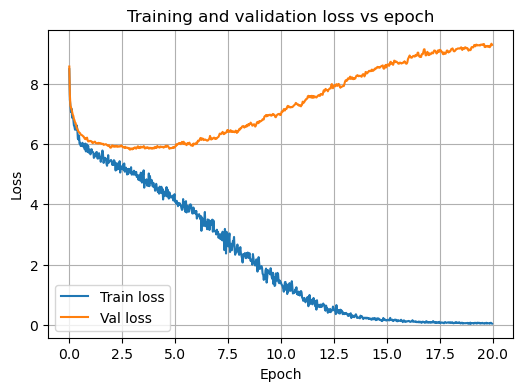

In [97]:
steps_per_epoch = len(train_dataloader) // eval_freq
epochs_for_points = np.arange(len(train_losses)) / steps_per_epoch

plt.figure(figsize=(6, 4))
plt.plot(epochs_for_points, train_losses, label="Train loss")
plt.plot(epochs_for_points, val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss vs epoch")
plt.legend()
plt.grid(True)
plt.show()

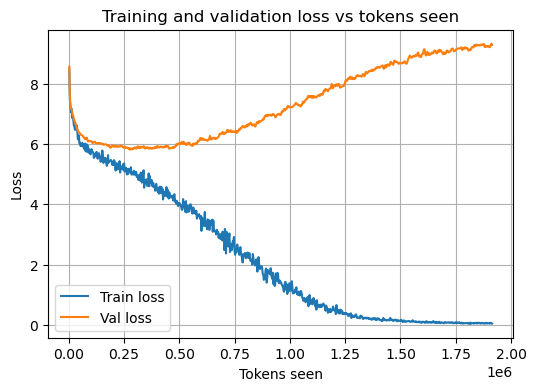

In [98]:
plt.figure(figsize=(6, 4))
plt.plot(tokens_seen, train_losses, label="Train loss")
plt.plot(tokens_seen, val_losses, label="Val loss")
plt.xlabel("Tokens seen")
plt.ylabel("Loss")
plt.title("Training and validation loss vs tokens seen")
plt.legend()
plt.grid(True)
plt.show()

In [99]:
input = "Every effort moves you "

batch = text_to_token_ids(input)
batch = batch.to(device)

generated_tokens = generate_text_simple(my_model, batch, 10, 256)

generated_text = token_ids_to_text(generated_tokens)

print(input + generated_text)

Every effort moves you          Their colours


## Understanding the temperature sampling

In [100]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

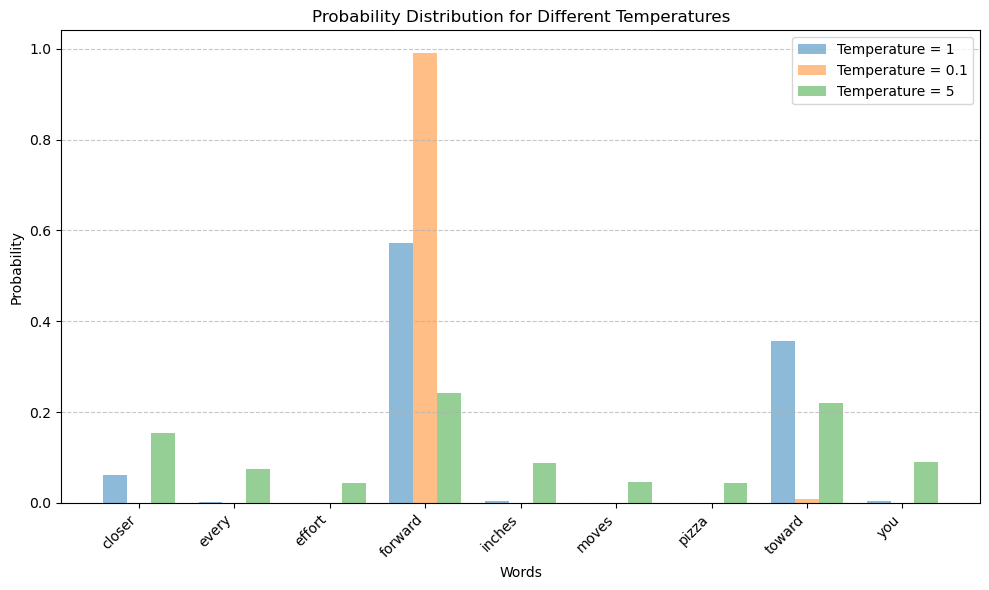

In [101]:
# Calculate probability distributions for different temperatures
prob_dist_1 = torch.softmax(next_token_logits / 1, dim=0)
prob_dist_01 = torch.softmax(next_token_logits / 0.1, dim=0)
prob_dist_5 = torch.softmax(next_token_logits / 5, dim=0)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(
    range(len(vocab)),
    prob_dist_1.numpy(),
    alpha=0.5,
    label='Temperature = 1',
    width=0.25
)
plt.bar(
    [i + 0.25 for i in range(len(vocab))],
    prob_dist_01.numpy(),
    alpha=0.5,
    label='Temperature = 0.1',
    width=0.25
)
plt.bar(
    [i + 0.5 for i in range(len(vocab))],
    prob_dist_5.numpy(),
    alpha=0.5,
    label='Temperature = 5',
    width=0.25
)

plt.xticks(
    [i + 0.25 for i in range(len(vocab))],
    list(vocab.keys()),
    rotation=45,
    ha='right'
)
plt.xlabel('Words')
plt.ylabel('Probability')
plt.title('Probability Distribution for Different Temperatures')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Understanding the top-k sampling

In [102]:
def top_k_logits(logits, k):
    # Ensure k is not larger than the vocabulary size
    k = min(k, logits.size(-1))
    if k <= 0:
        return logits
    # Find the indices of the top k logits
    top_k_values, top_k_indices = torch.topk(logits, k, dim=-1)
    # Create a mask for the top k logits
    mask = torch.full_like(logits, float('-inf'))
    # Use scatter_ to set the mask values for the top-k indices
    mask.scatter_(-1, top_k_indices, 0)
    # Apply the mask
    return logits + mask

k = 3
top_k = top_k_logits(next_token_logits, k)
prob_dist_top_k = torch.softmax(top_k, dim=0)

# Print the probabilities
for word, idx in vocab.items():
    print(f"{word}: {prob_dist_top_k[idx].item():.4f}")

closer: 0.0615
every: 0.0000
effort: 0.0000
forward: 0.5775
inches: 0.0000
moves: 0.0000
pizza: 0.0000
toward: 0.3610
you: 0.0000


## Creating a new generation function

In [103]:
def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None, eos_id=None):
    """
    Generate new tokens autoregressively using the model.
    
    Args:
        model: The GPT model to use for generation
        idx: Initial token indices, shape (batch_size, seq_len)
        max_new_tokens: Maximum number of tokens to generate
        context_size: Maximum context length (older tokens are truncated)
        temperature: Sampling temperature (0.0 = greedy, higher = more random)
        top_k: If set, only sample from top k most likely tokens
        eos_id: End-of-sequence token id (stops generation if encountered)
    
    Returns:
        generated_tokens: Tensor of shape (batch_size, max_new_tokens)
    """
    model.eval()
    batch_size, seq_len = idx.shape
    generated_tokens = torch.zeros((batch_size, max_new_tokens), dtype=torch.long, device=idx.device)
    current_context = idx.clone()
    
    for i in range(max_new_tokens):
        with torch.no_grad():
            # Get logits from model for current context
            logits = model(current_context)  # (batch_size, seq_len, vocab_size)
        
        # Only use logits from last position
        last_logits = logits[:, -1, :]  # (batch_size, vocab_size)
        
        # Apply top-k filtering if specified
        if top_k is not None:
            last_logits = top_k_logits(last_logits, top_k)
        
        # Sample next token based on temperature
        if temperature == 0.0:
            # Greedy decoding: always pick most likely token
            next_token = torch.argmax(last_logits, dim=-1)  # (batch_size,)
        else:
            # Stochastic sampling: sample according to probability distribution
            probs = F.softmax(last_logits / temperature, dim=-1)  # (batch_size, vocab_size)
            next_token = torch.multinomial(probs, num_samples=1).squeeze(-1)  # (batch_size,)
        
        # Store generated token
        generated_tokens[:, i] = next_token
        
        # Check for end-of-sequence token
        if eos_id is not None and (next_token == eos_id).any():
            break
        
        # Append new token to context
        next_token = next_token.unsqueeze(-1)  # (batch_size, 1)
        current_context = torch.cat([current_context, next_token], dim=1)
        
        # Truncate context if it exceeds maximum length
        if current_context.shape[1] > context_size:
            current_context = current_context[:, -context_size:]
    
    return generated_tokens

In [104]:
input = "Every effort moves you"

batch = text_to_token_ids(input)
batch = batch.to(device)

generated_tokens = generate(my_model, batch, 15, 256, 1.4, 25)

generated_text = token_ids_to_text(generated_tokens)

print(input + generated_text)

Every effort moves you not banished.”

attended himself any time? You have


## Saving the model

In [105]:
checkpoint_path = "../model/model_checkpoint.pth"

# Create a checkpoint dictionary
checkpoint = {
    "model_state_dict": my_model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    # "epoch": epoch,
    # "loss": loss,
}

# Save the checkpoint
torch.save(checkpoint, checkpoint_path)
print(f"Checkpoint saved to {checkpoint_path}")

Checkpoint saved to ../model/model_checkpoint.pth


In [106]:
checkpoint = torch.load(checkpoint_path)

# Load the model and optimizer states
my_model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Set the model to evaluation mode
my_model.eval()

# Optional: Print the model's state_dict keys to verify
print("Model's state_dict keys:", my_model.state_dict().keys())

generated_tokens = generate(my_model, batch, 15, 256, 1.4, 25)

generated_text = token_ids_to_text(generated_tokens)

print(input + generated_text)

C:\Users\edgar\AppData\Local\Temp\ipykernel_30624\2339529436.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model's state_dict keys: odict_keys(['token_embedding.weight', 'pos_embedding_layer.weight', 'transformer_blocks.0.layerNorm1.scale', 'transformer_blocks.0.layerNorm1.shift', 'transformer_blocks.0.mha.W_query.weight', 'transformer_blocks.0.mha.W_key.weight', 'transformer_blocks.0.mha.W_value.weight', 'transformer_blocks.0.mha.out_proj.weight', 'transformer_blocks.0.layerNorm2.scale', 'transformer_blocks.0.layerNorm2.shift', 'transformer_blocks.0.feedForward.layer1.weight', 'transformer_blocks.0.feedForward.layer1.bias', 'transformer_blocks.0.feedForward.layer2.weight', 'transformer_blocks.0.feedForward.layer2.bias', 'transformer_blocks.1.layerNorm1.scale', 'transformer_blocks.1.layerNorm1.shift', 'transformer_blocks.1.mha.W_query.weight', 'transformer_blocks.1.mha.W_key.weight', 'transformer_blocks.1.mha.W_value.weight', 'transformer_blocks.1.mha.out_proj.weight', 'transformer_blocks.1.layerNorm2.scale', 'transformer_blocks.1.layerNorm2.shift', 'transformer_blocks.1.feedForward.layer1.

## Loading pre-trained weights from OpenAI

In [107]:
sys.path.append(os.path.abspath("../src"))
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2("124M", "../model/gpt")

File already exists and is up-to-date: ../model/gpt\124M\checkpoint
File already exists and is up-to-date: ../model/gpt\124M\encoder.json
File already exists and is up-to-date: ../model/gpt\124M\hparams.json
File already exists and is up-to-date: ../model/gpt\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: ../model/gpt\124M\model.ckpt.index
File already exists and is up-to-date: ../model/gpt\124M\model.ckpt.meta
File already exists and is up-to-date: ../model/gpt\124M\vocab.bpe


In [108]:
for key in params.keys():
    print(key)
print('\n')

for key in settings.keys():
    print(key)

blocks
b
g
wpe
wte


n_vocab
n_ctx
n_embd
n_head
n_layer


In [109]:
with open('../model/gpt/124M/hparams.json', 'r') as f:
    hparams = json.load(f)

print("Hyperparameters loaded:")
print(hparams)

Hyperparameters loaded:
{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [110]:
def assign(target_tensor: torch.Tensor, source_array) -> torch.Tensor:
    source_tensor = torch.tensor(source_array, dtype=target_tensor.dtype)

    if target_tensor.shape != source_tensor.shape:
        raise ValueError(
            f"Incompatible shapes: target {tuple(target_tensor.shape)} "
            f"vs source {tuple(source_tensor.shape)}"
        )

    return source_tensor

In [111]:
def load_weights_into_gpt(model: GPTModel, params):
    emb_dim = model.emb_dim
    n_heads = model.n_heads
    
    with torch.no_grad():
        # --- Embeddings ---
        model.token_embedding.weight.copy_(
            assign(model.token_embedding.weight, params["wte"])
        )
        model.pos_embedding_layer.weight.copy_(
            assign(model.pos_embedding_layer.weight, params["wpe"])
        )
        
        # --- Blocs Transformer ---
        for i, block in enumerate(model.transformer_blocks):
            p_block = params["blocks"][i]
            
            # LayerNorm 1
            block.layerNorm1.scale.copy_(
                assign(block.layerNorm1.scale, p_block["ln_1"]["g"])
            )
            block.layerNorm1.shift.copy_(
                assign(block.layerNorm1.shift, p_block["ln_1"]["b"])
            )
            
            # --- ATTENTION : Gestion Correcte de c_attn ---
            W_qkv = p_block["attn"]["c_attn"]["w"]  # [768, 2304]
            b_qkv = p_block["attn"]["c_attn"]["b"]  # [2304]
            
            # Découpage sur la dimension de sortie (colonnes)
            W_q = W_qkv[:, 0*emb_dim:1*emb_dim]  # [768, 768]
            W_k = W_qkv[:, 1*emb_dim:2*emb_dim]
            W_v = W_qkv[:, 2*emb_dim:3*emb_dim]
            
            b_q = b_qkv[0*emb_dim:1*emb_dim]  # [768]
            b_k = b_qkv[1*emb_dim:2*emb_dim]
            b_v = b_qkv[2*emb_dim:3*emb_dim]
            
            # Vérification de shape (CRITIQUE)
            assert W_q.shape == (emb_dim, emb_dim), f"❌ W_q shape: {W_q.shape}"
            assert b_q.shape == (emb_dim,), f"❌ b_q shape: {b_q.shape}"
            
            # Copie dans les Linear (bias=False donc on ignore les biais)
            # PyTorch: Linear.weight est (out_features, in_features)
            block.mha.W_query.weight.copy_(assign(block.mha.W_query.weight, W_q.T))
            block.mha.W_query.bias.copy_(assign(block.mha.W_query.bias, b_q))

            block.mha.W_key.weight.copy_(assign(block.mha.W_key.weight, W_k.T))
            block.mha.W_key.bias.copy_(assign(block.mha.W_key.bias, b_k))

            block.mha.W_value.weight.copy_(assign(block.mha.W_value.weight, W_v.T))
            block.mha.W_value.bias.copy_(assign(block.mha.W_value.bias, b_v))
            
            # Projection de sortie
            W_o = p_block["attn"]["c_proj"]["w"]  # [768, 768]
            b_o = p_block["attn"]["c_proj"]["b"]
            block.mha.out_proj.weight.copy_(assign(block.mha.out_proj.weight, W_o.T))
            block.mha.out_proj.bias.copy_(assign(block.mha.out_proj.bias, b_o))
            
            # LayerNorm 2
            block.layerNorm2.scale.copy_(
                assign(block.layerNorm2.scale, p_block["ln_2"]["g"])
            )
            block.layerNorm2.shift.copy_(
                assign(block.layerNorm2.shift, p_block["ln_2"]["b"])
            )
            
            # --- MLP ---
            W1 = p_block["mlp"]["c_fc"]["w"]  # [768, 3072]
            b1 = p_block["mlp"]["c_fc"]["b"]  # [3072]
            
            assert W1.shape == (emb_dim, 4*emb_dim), f"❌ W1 shape: {W1.shape}"
            
            block.feedForward.layer1.weight.copy_(assign(block.feedForward.layer1.weight, W1.T))
            block.feedForward.layer1.bias.copy_(assign(block.feedForward.layer1.bias, b1))
            
            W2 = p_block["mlp"]["c_proj"]["w"]  # [3072, 768]
            b2 = p_block["mlp"]["c_proj"]["b"]  # [768]
            
            block.feedForward.layer2.weight.copy_(assign(block.feedForward.layer2.weight, W2.T))
            block.feedForward.layer2.bias.copy_(assign(block.feedForward.layer2.bias, b2))
        
        # LayerNorm final (stored at root level as 'g' and 'b')
        model.layerNorm.scale.copy_(
            assign(model.layerNorm.scale, params["g"])
        )
        model.layerNorm.shift.copy_(
            assign(model.layerNorm.shift, params["b"])
        )
        
        # Weight tying (inverseEmbedding == token_embedding)
        if hasattr(model, "inverseEmbedding"):
            model.inverseEmbedding.weight.copy_(
                assign(model.inverseEmbedding.weight, params["wte"])
            )

In [112]:
mapped_config = {
    "vocab_size": hparams["n_vocab"],
    "context_length": hparams["n_ctx"],
    "emb_dim": hparams["n_embd"],
    "n_heads": hparams["n_head"],
    "n_layers": hparams["n_layer"],
    "drop_rate": 0.1,
    "qkv_bias": True,
    "out_bias": True
}

model = GPTModel(mapped_config)
model.to(device)
load_weights_into_gpt(model, params)

In [ ]:
input = "Every effort moves you"

batch = text_to_token_ids(input)
batch = batch.to(device)

model.eval()

with torch.no_grad():
    generated_tokens = generate(model, batch, max_new_tokens=500, context_size=256, temperature=1, top_k=30)

generated_text = token_ids_to_text(generated_tokens)

print(input + generated_text)

Every effort moves you to that level of success which is required to keep your talent as good as possible.

Your talent is not merely a result of years of effort but is built upon the effort of others. Your hard work does not come out of a selfish effort


In [114]:
generated_tokens = generate(my_model, batch, max_new_tokens=10, context_size=256, temperature=1, top_k=30)

generated_text = token_ids_to_text(generated_tokens)

print(input + generated_text)

Every effort moves you alone that thou can disturb my life can no longer
